In [1]:
#Configuração para usar a base de dados de modo
#eficiente no google colab  --> comentar quando for rodar

from google.colab import drive

drive.mount('/content/drive')

PROJECT_PATH = '/content/drive/MyDrive/Competicao_DS_Arquivos'

!unzip $PROJECT_PATH/ieee-fraud-detection.zip

Mounted at /content/drive
Archive:  /content/drive/MyDrive/Competicao_DS_Arquivos/ieee-fraud-detection.zip
  inflating: sample_submission.csv   
  inflating: test_identity.csv       
  inflating: test_transaction.csv    
  inflating: train_identity.csv      
  inflating: train_transaction.csv   


In [2]:
import pandas as pd
import numpy as np
import gc

from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import ParameterGrid
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score

from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.linear_model import LogisticRegression

In [3]:
train_transaction = pd.read_csv("train_transaction.csv")
train_identity = pd.read_csv("train_identity.csv")

train_transaction = train_transaction.set_index("TransactionID")
train_transaction.drop([c for c in train_transaction.columns if c.startswith('V')], axis = 1,inplace = True)
train_identity = train_identity.set_index("TransactionID")
y = train_transaction['isFraud']
X_transaction = train_transaction.drop(['isFraud'],axis=1)
X_identity = train_identity

threshold  = np.quantile(X_transaction.TransactionDT,0.7)
X_train_transaction = X_transaction[X_transaction['TransactionDT'] < threshold]
X_val_transaction = X_transaction[X_transaction['TransactionDT'] >= threshold]
X_train_identity = X_identity.loc[X_identity.index.intersection(X_train_transaction.index)]
X_val_identity = X_identity.loc[X_identity.index.difference(X_train_transaction.index)]
y_train = y[y.index.intersection(X_train_transaction.index)]
y_val = y[y.index.difference(X_train_transaction.index)]

In [4]:
#input X deve ter as colunas addr1, addr2, TransactionAmt e D1 concatenadas 
# versoes NOVAS
class TransformerPreprocessamentoIdentity(BaseEstimator, TransformerMixin):

  transformers_fit = {}
  mM_pca_fit = ""
  Isolation_1 = ""
  Isolation_2 = ""
  pca_id_fit = ""
  cols_aplicar_fit = {}
  mM_id_fit =""

  def __init__(self):
    return 

  def fit(self, X, y = None):

    X = X.copy()

    #Ids
    id_cols = [c for c in X.columns if c.startswith('id_')]
    transformers = {}
    cols_aplicar = {}
    for c in id_cols:
      if X[c].dtype == 'object':
        if X[c].nunique() > 10:
          cols_aplicar[c] = "drop"
          X.drop(c,inplace= True,axis=1)
        else:
          cols_aplicar[c] = "label"
          le = LabelEncoder()
          X[c].fillna("Unknown",inplace = True)
          le.fit(list(X[c].astype(str).values))
          X[c] = le.transform(list(X[c].astype(str).values))
          transformers[c] = le
      else:
        X[c].fillna(-1,inplace = True)
        cols_aplicar[c] = "fill"

    #CustomFeature1
    adr1 =  X[['addr1_novo']].fillna(-1,axis=1) 
    adr2 =  X[['addr2_novo']].fillna(-1,axis=1)
    X_concat_custom_feat_1 = pd.concat([adr1['addr1_novo'],adr2['addr2_novo'],X['id_02']],axis = 1)
    clf_Outlier_1 = IsolationForest(random_state=42).fit(X_concat_custom_feat_1)
    
    #CustomFeature2
    epsilon = 1e-3
    freq_x_magnitude =  X[['TransactionAmt_novo']].fillna(-1,axis=1).to_numpy() / (X[['D1_novo']].fillna(-1,axis=1).to_numpy() + epsilon)
    df_riq = pd.DataFrame(freq_x_magnitude,columns=['freq_x_magn']).set_index(X.index).astype(int)
    X_concat_custom_feat_2 = pd.concat([df_riq['freq_x_magn'],X['id_02']],axis = 1)
    clf_Outlier_2 = IsolationForest(random_state=42).fit(X_concat_custom_feat_2)
    
    #Final
    id_cols = [c for c in X.columns if c.startswith('id_')]
    id_train_num = X[id_cols]
    pca_id = PCA(n_components = 0.95)
    pca_id_feat = pca_id.fit_transform(id_train_num)
    mM_id = MinMaxScaler()
    mM_id.fit(pca_id_feat)

    #Salvar valores na classe
    self.mM_pca_fit = mM_id
    self.transformers_fit = transformers
    self.Isolation_1 = clf_Outlier_1
    self.Isolation_2 = clf_Outlier_2
    self.mM_id_fit =  mM_id
    self.pca_id_fit = pca_id
    self.cols_aplicar_fit = cols_aplicar
    
    return self

  def transform(self, X, y = None):

    #DeviceInfo
    X.drop(["DeviceInfo"],inplace = True, axis = 1)

    #DeviceType
    X.DeviceType = X.DeviceType.map({'mobile': 0, 'desktop': 1})
    X.DeviceType.fillna(-1,inplace=True)

    #Ids
    id_cols = [c for c in X.columns if c.startswith('id_')]
    for c in id_cols:
      if self.cols_aplicar_fit[c] == 'drop':
        X.drop(c,inplace= True,axis=1)
      elif self.cols_aplicar_fit[c] == 'label':
        X[c].fillna("Unknown",inplace = True)
        X[c] = self.transformers_fit[c].transform(list(X[c].astype(str).values))
      else:
        X[c].fillna(-1,inplace = True)
    
    #CustomFeature1
    adr1 =  X[['addr1_novo']].fillna(-1,axis=1) 
    adr2 =  X[['addr2_novo']].fillna(-1,axis=1)
    X_concat_custom_feat_1 = pd.concat([adr1['addr1_novo'],adr2['addr2_novo'],X['id_02']],axis = 1)
    X_custom_feat_1_df = pd.DataFrame(self.Isolation_1.predict(X_concat_custom_feat_1),columns=['Outlier_tipo_1']).set_index(X.index)
    X.drop(['addr1_novo','addr2_novo'],axis =1, inplace = True)

    #CustomFeature2
    epsilon = 1e-3
    freq_x_magnitude =  X[['TransactionAmt_novo']].fillna(-1,axis=1).to_numpy() / (X[['D1_novo']].fillna(-1,axis=1).to_numpy() + epsilon)
    df_riq = pd.DataFrame(freq_x_magnitude,columns=['freq_x_magn']).set_index(X.index).astype(int)
    X_concat_custom_feat_2 = pd.concat([df_riq['freq_x_magn'],X['id_02']],axis = 1)
    X_custom_feat_2_df = pd.DataFrame(self.Isolation_2.predict(X_concat_custom_feat_2),columns=['Outlier_tipo_2']).set_index(X.index)
    X.drop(['TransactionAmt_novo','D1_novo'],axis =1, inplace = True)

    #Final
    id_cols = [c for c in X.columns if c.startswith('id_')]
    id_train_num = X[id_cols]
    pca_id_feat = self.pca_id_fit.transform(id_train_num)
    pca_id_feat = self.mM_id_fit.transform(pca_id_feat)
    pca_id_feat_df = pd.DataFrame(pca_id_feat, columns=['id']).set_index(X.index)
    feat_identity = pd.concat([pca_id_feat_df,X_custom_feat_1_df,X_custom_feat_2_df,X[['DeviceType']]],axis=1)

    return feat_identity

In [5]:
class TransformerPreprocessamentoTransaction(BaseEstimator, TransformerMixin):

  encProdCD_fit = ""
  le_card4_fit = ""
  le_card6_fit = ""
  tokens_email_P_fit = ""
  tokens_email_R_fit = ""
  M_le_fit = ""
  pca_M_fit = ""
  
  def __init__(self):
    return 

  def fit(self, X, y = None):
    X = X.copy()

    #ProductCD
    encProdCD = OneHotEncoder(handle_unknown='ignore',sparse = False)
    X['ProductCD'].fillna("Unknown",inplace = True)
    encProdCD.fit(X[['ProductCD']])

    #card4 e card6
    le_card4 = LabelEncoder()
    le_card6 = LabelEncoder()
    X['card4'].fillna("Unknown",inplace = True)
    X['card6'].fillna("Unknown",inplace = True)
    le_card4.fit(list(X['card4'].astype(str).values))
    le_card6.fit(list(X['card6'].astype(str).values))

    #emails
    tokens_email_P = {}
    for name in X['P_emaildomain'].unique().tolist():
      tokens_email_P[name] = 0
    tokens_email_P['Unknown'] = 0

    tokens_email_R = {}
    for name in X['R_emaildomain'].unique().tolist():
      tokens_email_R[name] = 0
    tokens_email_R['Unknown'] = 0

    for line in X['P_emaildomain']:
      if line in tokens_email_P.keys():
        tokens_email_P[line]+=1
      else:
        tokens_email_P['Unknown']+=1

    for line in X['R_emaildomain']:
      if line in tokens_email_R.keys():
        tokens_email_R[line]+=1
      else:
        tokens_email_R['Unknown']+=1

    tam_P = len(X['P_emaildomain'])
    for key in tokens_email_P.keys():
      tokens_email_P[key] = tokens_email_P[key]/tam_P

    tam_R = len(X['R_emaildomain'])
    for key in tokens_email_R.keys():
      tokens_email_R[key] = tokens_email_R[key]/tam_R
    
    #Features M
    M_le = {}
    for i in range(9):      
      X['M%d'%(i+1)].fillna("Unknown",inplace = True)     
      le = LabelEncoder()     
      le.fit(list(X['M%d'%(i+1)].astype(str).values))
      X['M%d'%(i+1)] = le.transform(list(X['M%d'%(i+1)].astype(str).values))   
      M_le['M%d'%(i+1)] = le
    
    pca_M = PCA(n_components=0.95)
    pca_M.fit(X[['M%d'%(i+1) for i in range(9)]])

    #Salvar os parametros
    self.encProdCD_fit = encProdCD
    self.le_card4_fit = le_card4
    self.le_card6_fit = le_card6
    self.tokens_email_P_fit = tokens_email_P
    self.tokens_email_R_fit = tokens_email_R
    self.M_le_fit = M_le
    self.pca_M_fit = pca_M

    return self

  def transform(self, X, y = None):

    #Features numericas apenas recebem um valor que representa nulo
    non_obj_cols = [c for c in X.columns if X[c].dtype != 'object']
    X[non_obj_cols] = X[non_obj_cols].fillna(-1)

    #ProductCD
    X['ProductCD'].fillna("Unknown",inplace = True)
    X.join(pd.DataFrame(self.encProdCD_fit.transform(X[['ProductCD']])).set_index(X.index)) 
    X.drop(['ProductCD'],axis=1,inplace=True)

    #card4 e card6
    X['card4'].fillna("Unknown",inplace = True)
    X['card6'].fillna("Unknown",inplace = True)
    X['card4'] = self.le_card4_fit.transform(list(X['card4'].astype(str).values))
    X['card6'] = self.le_card6_fit.transform(list(X['card6'].astype(str).values))

    #emails
    X['P_emaildomain'] = X['P_emaildomain'].map(self.tokens_email_P_fit).apply(lambda p: -p*np.log2(p))
    X['R_emaildomain'] = X['R_emaildomain'].map(self.tokens_email_R_fit).apply(lambda p: -p*np.log2(p))

    #Features M
    for i in range(9):      
      X['M%d'%(i+1)].fillna("Unknown",inplace = True)        
      X['M%d'%(i+1)] = self.M_le_fit['M%d'%(i+1)].transform(list(X['M%d'%(i+1)].astype(str).values))
    
    X.join(pd.DataFrame(self.pca_M_fit.transform(X[['M%d'%(i+1) for i in range(9)]])).set_index(X.index))
    X.drop(['M%d'%(i+1) for i in range(9)],axis=1,inplace=True)

    return X
    

Questão 3 

b) Faça uso de uma técnica de modelagem ainda não falada na disciplina. Essa
técnica não precisa ser uma modelo de regressão, ela pode ser uma técnica

Com relação a esta secção, a técnica de modelagem de IsolationForest, usada para feature engineering para variáveis do dataset Identity, não fora utilizada até o momento na disciplina.


a) Aprimore o pipeline desenvolvido em aula para que seja possível comparar
mais de uma técnica de modelagem usando um mesmo grid-search;

* Obs.: não use cross-validation!!! Separe a base em treino e validação
usando o campo referente a data da transação;

Para isto utilizou-se este seguinte encapsulamento por meio de herança da base de sklearn.

In [6]:
class ClfSwitcher(BaseEstimator):

  def __init__(self,estimator = RandomForestClassifier(n_estimators=100,max_depth=3)):
      self.estimator = estimator
      return 

  def fit(self, X, y=None, **kwargs):
      self.estimator.fit(X, y)
      return self

  def predict(self, X, y=None):
      return self.estimator.predict(X)

  def predict_proba(self, X):
      return self.estimator.predict_proba(X)

  def score(self, X, y):
      return self.estimator.score(X, y)

O pipeline utilizado faz uso de um processamento seletivo das colunas, através do paradigma identity/transaction, aplicando cada preprocessamento separadamente.

In [7]:
cols_identity = X_identity.columns.tolist() + ['D1_novo','TransactionAmt_novo','addr1_novo','addr2_novo']
cols_transaction = X_transaction.columns.tolist()

Em seguida aplica-se uma pca de forma a manter 95% da variância do dataset original.

In [8]:
pipeline = Pipeline(steps = [
    ('Preprocessamento', ColumnTransformer(transformers = [
                                                              ('PreproIdentity',TransformerPreprocessamentoIdentity(),cols_identity),
                                                              ('PreproTransaction',TransformerPreprocessamentoTransaction(),cols_transaction)
                                                          ], remainder = 'passthrough')),
    ('pca', PCA(n_components = 0.95)),
    ('clf', ClfSwitcher())
])

(Por conta de limitações de tempo de execução e memória, utiliza-se um coletor de lixo).

In [9]:
gc.collect()

202

In [10]:
X_train_total = X_train_transaction.join(
    pd.merge(X_train_identity, X_train_transaction[['D1','TransactionAmt','addr1','addr2']], left_index=True, right_index=True).rename(columns = { 
    'D1' : 'D1_novo','TransactionAmt' : 'TransactionAmt_novo','addr1' : 'addr1_novo','addr2' :'addr2_novo'
}) )

In [11]:
X_val_total = X_val_transaction.join(
    pd.merge(X_val_identity, X_val_transaction[['D1','TransactionAmt','addr1','addr2']], left_index=True, right_index=True).rename(columns = { 
    'D1' : 'D1_novo','TransactionAmt' : 'TransactionAmt_novo','addr1' : 'addr1_novo','addr2' :'addr2_novo'
}) )

In [12]:
gc.collect()

100

Por questões de tempo apenas testam-se os seguintes modelos/parâmetros, porém o pipeline desenvolvido é capaz de adequar-se a mais testes sem problemas.

In [13]:
parametros = [
    {
        'clf__estimator': [LogisticRegression()],
        'clf__estimator__C' : [1e-2,1e-1,1,10],
        'clf__estimator__solver' : ['saga'],
        'clf__estimator__penalty': ['l1', 'l2', 'none']
    },
    {
        'clf__estimator': [MLPClassifier()],
        'clf__estimator__activation' : ['logistic', 'tanh', 'relu'],
        'clf__estimator__learning_rate' : ['constant','invscaling','adaptive']
    },
    {
        'clf__estimator': [RandomForestClassifier()],
        'clf__estimator__n_estimators' : [10,50,100],
        'clf__estimator__max_depth' : [2,3]
    },
]

Questão 4

a) Comparar vários modelos candidatos e escolher o melhor de acordo com a
AUC;

In [15]:
best_score = 0.0

for g in ParameterGrid(parametros):
  print(g)
  gc.collect()
  
  pipeline.set_params(**g)
  pipeline.fit(X_train_total,y_train)

  y_preds_val = pipeline.predict_proba(X_val_total.copy())
  y_val_pred_df = pd.DataFrame(y_preds_val).set_index(X_val_total.index).iloc[:,1]

  curr_score = roc_auc_score(y_val[y_val.index.intersection(y_val_pred_df.index)],y_val_pred_df)
  if  curr_score > best_score:
    best_score = curr_score
    best_grid = g
  gc.collect()

{'clf__estimator': LogisticRegression(C=0.01, penalty='l1', solver='saga'), 'clf__estimator__C': 0.01, 'clf__estimator__penalty': 'l1', 'clf__estimator__solver': 'saga'}
{'clf__estimator': LogisticRegression(C=0.01, penalty='l1', solver='saga'), 'clf__estimator__C': 0.01, 'clf__estimator__penalty': 'l2', 'clf__estimator__solver': 'saga'}
{'clf__estimator': LogisticRegression(C=0.01, solver='saga'), 'clf__estimator__C': 0.01, 'clf__estimator__penalty': 'none', 'clf__estimator__solver': 'saga'}


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"


{'clf__estimator': LogisticRegression(C=0.01, penalty='none', solver='saga'), 'clf__estimator__C': 0.1, 'clf__estimator__penalty': 'l1', 'clf__estimator__solver': 'saga'}
{'clf__estimator': LogisticRegression(C=0.1, penalty='l1', solver='saga'), 'clf__estimator__C': 0.1, 'clf__estimator__penalty': 'l2', 'clf__estimator__solver': 'saga'}
{'clf__estimator': LogisticRegression(C=0.1, solver='saga'), 'clf__estimator__C': 0.1, 'clf__estimator__penalty': 'none', 'clf__estimator__solver': 'saga'}


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"


{'clf__estimator': LogisticRegression(C=0.1, penalty='none', solver='saga'), 'clf__estimator__C': 1, 'clf__estimator__penalty': 'l1', 'clf__estimator__solver': 'saga'}
{'clf__estimator': LogisticRegression(C=1, penalty='l1', solver='saga'), 'clf__estimator__C': 1, 'clf__estimator__penalty': 'l2', 'clf__estimator__solver': 'saga'}
{'clf__estimator': LogisticRegression(C=1, solver='saga'), 'clf__estimator__C': 1, 'clf__estimator__penalty': 'none', 'clf__estimator__solver': 'saga'}
{'clf__estimator': LogisticRegression(C=1, penalty='none', solver='saga'), 'clf__estimator__C': 10, 'clf__estimator__penalty': 'l1', 'clf__estimator__solver': 'saga'}
{'clf__estimator': LogisticRegression(C=10, penalty='l1', solver='saga'), 'clf__estimator__C': 10, 'clf__estimator__penalty': 'l2', 'clf__estimator__solver': 'saga'}
{'clf__estimator': LogisticRegression(C=10, solver='saga'), 'clf__estimator__C': 10, 'clf__estimator__penalty': 'none', 'clf__estimator__solver': 'saga'}


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"


{'clf__estimator': MLPClassifier(), 'clf__estimator__activation': 'logistic', 'clf__estimator__learning_rate': 'constant'}
{'clf__estimator': MLPClassifier(activation='logistic'), 'clf__estimator__activation': 'logistic', 'clf__estimator__learning_rate': 'invscaling'}
{'clf__estimator': MLPClassifier(activation='logistic', learning_rate='invscaling'), 'clf__estimator__activation': 'logistic', 'clf__estimator__learning_rate': 'adaptive'}
{'clf__estimator': MLPClassifier(activation='logistic', learning_rate='adaptive'), 'clf__estimator__activation': 'tanh', 'clf__estimator__learning_rate': 'constant'}
{'clf__estimator': MLPClassifier(activation='tanh'), 'clf__estimator__activation': 'tanh', 'clf__estimator__learning_rate': 'invscaling'}
{'clf__estimator': MLPClassifier(activation='tanh', learning_rate='invscaling'), 'clf__estimator__activation': 'tanh', 'clf__estimator__learning_rate': 'adaptive'}
{'clf__estimator': MLPClassifier(activation='tanh', learning_rate='adaptive'), 'clf__estima

Verificando o modelo final 

In [16]:
best_grid

{'clf__estimator': LogisticRegression(C=10, penalty='none', solver='saga'),
 'clf__estimator__C': 0.01,
 'clf__estimator__penalty': 'l1',
 'clf__estimator__solver': 'saga'}

In [17]:
best_score

0.5079611221488893

Temos um score mediocre, provavelmente por conta de todas as features que foram descartadas, porém é o melhor conseguido e a maneira com que fora conseguido, dado um pouco mais de processamento das variáveis (e uso das variáveis vesta extras) seria provavelmente mais útil. 

Com isso vamos realizar as previsões no conjunto de teste, depois de retreinar o modelo em todo o conjunto.

b) Gerar os resultados do melhor modelo na base de teste e enviar para o
Kaggle. Colocar alguma evidência do envio no projeto entregue;

In [18]:
#fitar no dataset inteiro, pegar test, fazer os PREDICTS, enviar no formato adequado, mandar print

X_total_para_fit = X_train_total.append(X_val_total)

pipeline.set_params(**best_grid)
pipeline.fit(X_total_para_fit,y)

test_transaction = pd.read_csv("test_transaction.csv")
test_identity = pd.read_csv("test_identity.csv")

test_transaction = test_transaction.set_index("TransactionID")
test_transaction.drop([c for c in test_transaction.columns if c.startswith('V')], axis = 1,inplace = True)
test_identity = test_identity.set_index("TransactionID")

X_teste = test_transaction.join(
    pd.merge(test_identity, test_transaction[['D1','TransactionAmt','addr1','addr2']], left_index=True, right_index=True).rename(columns = { 
    'D1' : 'D1_novo','TransactionAmt' : 'TransactionAmt_novo','addr1' : 'addr1_novo','addr2' :'addr2_novo'
}) )

Nota-se que ocorre uma pequena diferença no nome das classes de id.

In [19]:
X_teste

,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,...,id-05,id-06,id-07,id-08,id-09,id-10,id-11,id-12,id-13,id-14,id-15,id-16,id-17,id-18,id-19,id-20,id-21,id-22,id-23,id-24,id-25,id-26,id-27,id-28,id-29,id-30,id-31,id-32,id-33,id-34,id-35,id-36,id-37,id-38,DeviceType,DeviceInfo,D1_novo,TransactionAmt_novo,addr1_novo,addr2_novo
TransactionID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3663549,18403224,31.950,W,10409,111.0,150.0,visa,226.0,debit,170.0,87.0,1.0,NaN,gmail.com,NaN,6.0,6.0,0.0,0.0,3.0,4.0,0.0,0.0,6.0,0.0,5.0,1.0,115.0,6.0,419.0,419.0,27.0,398.0,27.0,NaN,NaN,NaN,NaN,418.0,203.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3663550,18403263,49.000,W,4272,111.0,150.0,visa,226.0,debit,299.0,87.0,4.0,NaN,aol.com,NaN,3.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,1.0,1.0,12.0,2.0,149.0,149.0,7.0,634.0,7.0,NaN,NaN,NaN,NaN,231.0,634.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3663551,18403310,171.000,W,4476,574.0,150.0,visa,226.0,debit,472.0,87.0,2635.0,NaN,hotmail.com,NaN,2.0,2.0,0.0,0.0,0.0,5.0,0.0,0.0,4.0,0.0,2.0,0.0,22.0,2.0,137.0,137.0,10.0,97.0,10.0,NaN,NaN,NaN,NaN,136.0,136.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3663552,18403310,284.950,W,10989,360.0,150.0,visa,166.0,debit,205.0,87.0,17.0,NaN,gmail.com,NaN,5.0,2.0,0.0,0.0,1.0,1.0,0.0,0.0,2.0,0.0,2.0,0.0,7.0,4.0,42.0,42.0,41.0,242.0,41.0,NaN,NaN,NaN,NaN,242.0,242.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3663553,18403317,67.950,W,18018,452.0,150.0,mastercard,117.0,debit,264.0,87.0,6.0,NaN,gmail.com,NaN,6.0,6.0,0.0,0.0,2.0,5.0,0.0,0.0,5.0,0.0,6.0,0.0,14.0,6.0,22.0,22.0,0.0,22.0,0.0,NaN,NaN,NaN,NaN,22.0,22.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4170235,34214279,94.679,C,13832,375.0,185.0,mastercard,224.0,debit,284.0,60.0,NaN,NaN,gmail.com,gmail.com,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,0.0,NaN,NaN,NaN,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4170236,34214287,12.173,C,3154,408.0,185.0,mastercard,224.0,debit,NaN,NaN,NaN,157.0,hotmail.com,hotmail.com,1.0,3.0,0.0,1.0,0.0,1.0,1.0,2.0,0.0,2.0,1.0,1.0,3.0,1.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,NaN,NaN,0.0,NaN,...,-3.0,-10.0,NaN,NaN,NaN,NaN,100.0,NotFound,27.0,NaN,New,NotFound,225.0,15.0,176.0,507.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,chrome 43.0 for android,NaN,NaN,NaN,F,F,T,F,mobile,ALE-L23 Build/HuaweiALE-L23,16.0,12.173,NaN,NaN
4170237,34214326,49.000,W,16661,490.0,150.0,visa,226.0,debit,327.0,87.0,NaN,NaN,hotmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


O que é corrigido antes de passar para a pipeline.

In [29]:
dict1 = {"id-0%d"%(i+1) : "id_0%d"%(i+1) for i in range(9)}
dict2 = {"id-%d"%(i+1) : "id_%d"%(i+1) for i in range(9,38)}
dict1.update(dict2)

X_teste = X_teste.rename(columns = dict1)

Entretando ao executar o código, nota-se que existe uma mensagem de erro que avisa a possibilidade de valores nulos ou infinitos. 

Os valores nulos provavelmente não são pois o preprocessamento já realiza essa conversão, além disso, manualmente preenchendo valores nulos já fora feito, para fins de erros, o que mesmo assim não fora resolvido.

Checagem de valores infinitos é feita logo abaixo, porém nada foi encontrado.

Sendo assim, esta parte não pode ser executada, por algum erro desconhecido. Dado que o conjunto de teste possui uma modificação no nome das colunas id, não é impossível de se esperar que alguma variável/tipo está distinto para com o conjunto de treino, porém não consegui localizar o erro.

In [47]:
for c in X_teste.columns:
  if X_teste[c].dtype == 'object':
    X_teste[c].fillna("Unknown", inplace = True)
  else:
    X_teste[c].fillna(-1, inplace = True)

In [44]:
for c in X_teste.columns:
  if X_teste[c].dtype != 'object':
    print(X_teste[c].max())
    print(X_teste[c].min())

34214345
18403224
10270.0
0.018000000000000002
18397
1001
600.0
-1.0
232.0
-1.0
237.0
-1.0
540.0
-1.0
102.0
-1.0
8081.0
-1.0
9213.0
-1.0
2950.0
-1.0
3275.0
-1.0
31.0
-1.0
1601.0
-1.0
376.0
-1.0
1601.0
-1.0
1621.0
-1.0
1005.0
-1.0
572.0
-1.0
881.0
-1.0
2234.0
-1.0
2234.0
-1.0
1562.0
-1.0
797.0
-1.0
641.0
-1.0
641.0
-1.0
1076.0
-1.0
1091.0
-1.0
1088.0
-1.0
1091.0
-1.0
1088.0
-1.0
2029.5833740234373
-1.0
0.9583330154418944
-1.0
1091.0
-1.0
883.0
-1.0
879.0
-1.0
1066.0
-1.0
1085.0
-1.0
1091.0
-1.0
0.0
-100.0
999869.0
-1.0
11.0
-12.0
0.0
-19.0
52.0
-81.0
0.0
-100.0
59.0
-41.0
0.0
-100.0
16.0
-32.0
0.0
-100.0
100.0
-1.0
63.0
-1.0
720.0
-720.0
228.0
-1.0
29.0
-1.0
670.0
-1.0
660.0
-1.0
854.0
-1.0
44.0
-1.0
26.0
-1.0
549.0
-1.0
216.0
-1.0
48.0
-1.0
640.0
-1.0
2000.0
-1.0
540.0
-1.0
102.0
-1.0


In [45]:
def _assert_all_finite(X):
    """Like assert_all_finite, but only for ndarray."""
    X = np.asanyarray(X)
    if (X.dtype.char in np.typecodes['AllFloat'] and not np.isfinite(X.sum())
            and not np.isfinite(X).all()):
        raise ValueError("Input contains NaN, infinity"
                         " or a value too large for %r." % X.dtype)

In [46]:
_assert_all_finite(X_teste) #passou no teste, nao ha valores infinitos

In [42]:
 y_preds_teste = pipeline.predict(X_teste) #mesmo assim o erro ocorre

ValueError: ignored

Questão 5 

a) Ao executar o predict_proba podemos obter os scores (“probabilidades”)
de cada transação ser uma fraude. Numa situação prática deve-se escolher
um ponto de corte a partir do qual as transações serão consideradas como
fraude e barradas/bloqueadas. Escolha um bom valor de ponto de corte
considerando:
* O valor monetário perdido em uma fraude (prejuízo);
* O valor bloqueado numa transação que não era fraude (ele
provavelmente gera algum prejuízo, dado que o cliente pode migrar
para o concorrente)
* E uma taxa aceitável de falsos positivos, dado que cada falso positivo
causa um transtorno para um cliente e pode levar a empresa a
perdê-lo.

Uma boa noção de ponto de corte deve considerar quantos valores que realmente são esperados em média pertencerem a fraudes. No caso de y_train, temos que a quantidade de fraudes é de:

In [60]:
y_train.mean() * 100

3.516878014795175

Aproximadamente 3,5%. Em y_val:

In [62]:
y_val.mean()*100

3.4572876802023007

Uma proporção incrivelmente semelhante, sendo assim, espera-se em média 3,5% de fraudes (assumindo que as transações passadas no conjunto de treino sejam todas as realmente efetivadas, pois as vezes as testadas **já estão** dentre as mais suspeitas. 

Portanto, em termos de ordem de grandeza, devemos realizar um corte de forma que aproximadamente apenas 3,5% das transações sejam barradas.

Porém vamos verificar quanto que espera-se perder em uma fraude:


In [65]:
train_transaction[train_transaction['isFraud'] == 1]['TransactionAmt'].mean()

149.2447785897534

Espera-se perder 150 dólares em média em uma transacao fraudulenta, o que não é pouco, com valores extremos

In [69]:
dinheiro = train_transaction[train_transaction['isFraud'] == 1].TransactionAmt

In [76]:
dinheiro.mean(), dinheiro.var() , dinheiro.median()

(149.2447785897534, 53922.48863160977, 75.0)

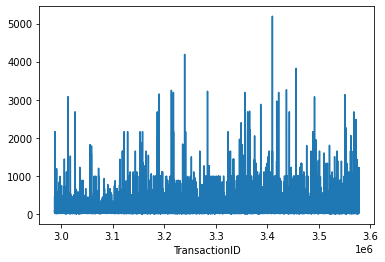

In [75]:
dinheiro.plot()

Como espera-se perder em média 150 dol, mas 50% dos valores estão acima de 75 dol, isso implica que em uma quantidade não desprezível de vezes ocorre que perde-se quase o dobro da mediana, o que nos mostra que a metade das fraudes são com valores menores que a média, mas aqueles que são acima da média são **muito** acima da média a ponto de divergir a média da mediana neste ponto.

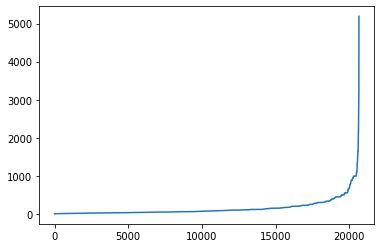

In [83]:
import matplotlib.pyplot as plt

plt.plot(range(len(dinheiro)), dinheiro.sort_values())

Caracterizando uma distribuição próxima de exponencial

Por conta de dificuldades na manipulação do preprocessamento, será difícil testar qual seria o ponto em especial, porém o melhor seria aplicar o seguinte procedimento:

* Dado que a distribuição é exponencial, "fitar" a curva característica desta (para constante A = 1/média: p(x) = A*exp(-Ax) ).

* Assim, verificar quanto que a distribuição é diferente de exponencial (fazendo, por exemplo, um teste chi-squared).

* O ponto escolhido deve ser tal que é maior que a probabilidade de a distribuição estar incorreta (ou seja, se a distribuição tiver uma probabilidade de 1% de estar incorreta, o valor de corte deve ser maior que 1%, pois não podemos afirmar nada abaixo deste numero).

* Em segundo lugar, sabemos que não existem muitas fraudes, portanto a probabilidade deve ser maior que a probabilidade de que é uma fraude dado que é um certo valor.

* Juntando essas duas convenções, é necessário (porém não o suficiente) que a probabilidade seja maior que o máximo entre a probabilidade que é fraude e a probabilidade que o modelo esta correto ( p >= max( p_model_fitness, p_fraude) ) 

* Utilizando-nos da regra de Bayes: ( P(F|Valor) = P(Valor|F) * P(F) / P(Valor)  = [P(Valor|F)/P(Valor)] * 0,035 ). O termo do denominador pode ser aproximado pela proporção da distribuição esperada pelo treino (pois já estamos assumindo neste caso p > p_model_fitness, logo é seguro assumir corretude desta hipótese). O termos P(Valor|F) é aproximado pela proporção esperada de valores menores ou iguais a esse na distribuição exponencial das fraudes, ou seja, a distribuição cumulativa, logo: P(Valor|F) = 1 - exp(-A*Valor). 

* Enfim, dadas estas considerações, a probabilidade estimada pelo modelo ( P(F|Valor) ) deve ser maior-igual que a threshold mínima (max( p_model_fitness, p_fraude)) e próxima da probabilidade estimada analiticamente  ( (1 - exp(-A*Valor)) * 0,035 / P(Valor) ). Sendo assim dada uma grande confiança na chance de ser fraude. 

* Como o valor monetário perdido é maior (tanto em média quanto em mediana) espera-se que um ponto de corte que segue a risca a distribuição real. Com isso, se P(F|Valor)_modelo for aproximadamente igual ao valor esperado analiticamente ( (1 - exp(-A*Valor)) * 0,035 / P(Valor) ) temos de bloquear a transação.

* A definição de aproximadamente igual deve seguir o seguinte critério: Se o modelo errar, o prejuízo não deve ser maior que o valor médio esperado, assim, o ponto de corte deve ser tal que [P(F|Valor)_modelo/P(F|Valor)_analitico]*Valor < ValorMedio.

Assim a fraude é bloqueada se todas as condições forem cumpridas:

- P(F|Valor)_modelo >= max( p_model_fitness, p_fraude)
- P(F|Valor)_modelo >= P(F|Valor)_analitica = (1 - exp(-A*Valor)) * 0,035 / P(Valor)
- P(F|Valor)_modelo > (ValorMedio/Valor)P(F|Valor)_analitico = (proporção de perda) * (probabilidade esperada analiticamente de estar errado)

Estes critérios nos dão uma margem em que não espera-se perder muitos clientes pois tem-se muita segurança na corretude do modelo, sendo que caso seja detectada fraude, a proporção era realmente muito grande.

In [85]:
train_transaction['TransactionAmt'].mean(), train_transaction['TransactionAmt'].median()

(135.02717637293821, 68.769)